# Traffic Accidents by Each Police Precinct District in Davidson County

In [1]:
from shapely.geometry import Point
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import folium
from folium.plugins import MarkerCluster
from folium.plugins import FastMarkerCluster

#### For region, I'm using Davidson County Police Precinct District Outlines. Let's import and check the first five rows.
- Source: https://data.nashville.gov/Police/Police-Precinct-District-Outlines-GIS-/hknv-udny

In [2]:
policedistricts = gpd.read_file('../data/policeprecinctdistricts.geojson')
print(policedistricts.crs)
policedistricts.head( )

epsg:4326


,precinct,shape_area,shape_len,geometry
0,CENTRAL,98541971.0257,46234.6717307,"MULTIPOLYGON (((-86.77525 36.14894, -86.77649 ..."
1,EAST,562260180.986,90261.1338967,"MULTIPOLYGON (((-86.74977 36.24057, -86.74955 ..."
2,HERMITAGE,2496337143.44,521944.947628,"MULTIPOLYGON (((-86.61306 36.24427, -86.61038 ..."
3,MADISON,1913402934.01,254564.86409,"MULTIPOLYGON (((-86.74955 36.24047, -86.74977 ..."
4,MIDTOWN-HILLS,1317030605.73,187104.273068,"MULTIPOLYGON (((-86.77935 36.14855, -86.77912 ..."


In [3]:
# Check that it's a geodataframe:

type(policedistricts)

geopandas.geodataframe.GeoDataFrame

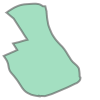

In [6]:
# Check the geometry of the first police district in the region:

policedistricts.loc[0, 'geometry']

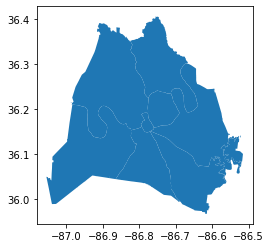

In [7]:
# Plot the geodataframe of the region:

policedistricts.plot();

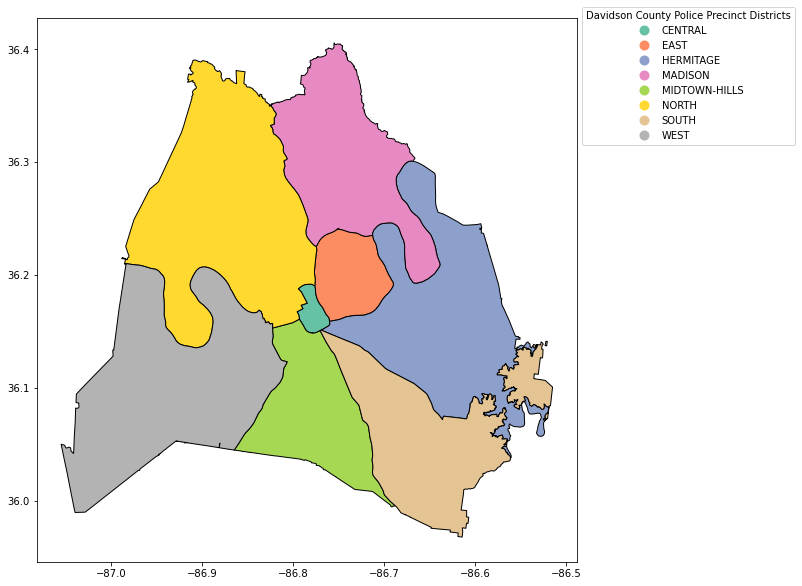

In [10]:
# Jazz up the region with colors denoting each police precinct district along with a legend:

leg_kwds = {'title': 'Davidson County Police Precinct Districts', 'loc': 'upper left', 
            'bbox_to_anchor': (1, 1.03), 'ncol': 1}

policedistricts.plot(column = 'precinct', figsize=(10, 10),
              edgecolor = 'black',
              legend = True, legend_kwds = leg_kwds, 
              cmap = 'Set2')
plt.show()

#### For points, I'm using Traffic Accidents.
- Source: https://data.nashville.gov/Police/Traffic-Accidents/6v6w-hpcw

In [12]:
# Removed unwanted columns from Traffic_Accidents.csv:

traffic_accidents = pd.read_csv('../data/Traffic_Accidents_cleaned.csv')
print(traffic_accidents.shape)
traffic_accidents.head(3)

(214914, 12)


,Accident Number,Date and Time,Number of Motor Vehicles,Collision Type Description,Weather Description,Street Address,City,ZIP,Precinct,Latitude,Longitude,Mapped Location
0,20200606233,9/21/2020 18:37,1.0,NOT COLLISION W/MOTOR VEHICLE-TRANSPORT,CLEAR,LEWIS ST & FAIN ST,NASHVILLE,37210.0,HERMIT,36.1518,-86.7580,POINT (-86.758 36.1518)
1,20200603908,9/20/2020 0:00,1.0,NOT COLLISION W/MOTOR VEHICLE-TRANSPORT,CLEAR,RICHMOND HILL DR & CARTERWOOD DR,NASHVILLE,37207.0,MADISO,36.2323,-86.7733,POINT (-86.7733 36.2323)
2,20200604395,9/20/2020 19:20,1.0,NOT COLLISION W/MOTOR VEHICLE-TRANSPORT,NaN,SHUTE LN & SAUNDERSVILLE RD,OLD HICKORY,37138.0,HERMIT,36.2267,-86.6032,POINT (-86.6032 36.2267)


In [14]:
# Create a geometry column with POINT datatype out of traffic accidents:

traffic_accidents['geometry'] = traffic_accidents.apply(lambda x: Point((x.Longitude, 
                                                         x.Latitude)), 
                                        axis=1)
traffic_accidents.head(3)

,Accident Number,Date and Time,Number of Motor Vehicles,Collision Type Description,Weather Description,Street Address,City,ZIP,Precinct,Latitude,Longitude,Mapped Location,geometry
0,20200606233,9/21/2020 18:37,1.0,NOT COLLISION W/MOTOR VEHICLE-TRANSPORT,CLEAR,LEWIS ST & FAIN ST,NASHVILLE,37210.0,HERMIT,36.1518,-86.7580,POINT (-86.758 36.1518),POINT (-86.758 36.1518)
1,20200603908,9/20/2020 0:00,1.0,NOT COLLISION W/MOTOR VEHICLE-TRANSPORT,CLEAR,RICHMOND HILL DR & CARTERWOOD DR,NASHVILLE,37207.0,MADISO,36.2323,-86.7733,POINT (-86.7733 36.2323),POINT (-86.77330000000001 36.2323)
2,20200604395,9/20/2020 19:20,1.0,NOT COLLISION W/MOTOR VEHICLE-TRANSPORT,NaN,SHUTE LN & SAUNDERSVILLE RD,OLD HICKORY,37138.0,HERMIT,36.2267,-86.6032,POINT (-86.6032 36.2267),POINT (-86.6032 36.2267)


In [16]:
# I want the crs of traffic accidents to match that of police districts, namely EPSG:4326
policedistricts.crs

<Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: World
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

In [17]:
ta_geo = gpd.GeoDataFrame(traffic_accidents, 
                           crs = policedistricts.crs, 
                           geometry = traffic_accidents['geometry'])

In [18]:
type(ta_geo) # Hooray, it is now a geodataframe!

geopandas.geodataframe.GeoDataFrame

#### Spatial join the two geodataframes together
- For policedistricts, keep columns 'precinct' and 'geometry'

In [19]:
policedistricts = policedistricts[['precinct', 'geometry']]

In [21]:
ta_by_pd = gpd.sjoin(ta_geo, policedistricts, op = 'within')
ta_by_pd.head()

,Accident Number,Date and Time,Number of Motor Vehicles,Collision Type Description,Weather Description,Street Address,City,ZIP,Precinct,Latitude,Longitude,Mapped Location,geometry,index_right,precinct
0,20200606233,9/21/2020 18:37,1.0,NOT COLLISION W/MOTOR VEHICLE-TRANSPORT,CLEAR,LEWIS ST & FAIN ST,NASHVILLE,37210.0,HERMIT,36.1518,-86.7580,POINT (-86.758 36.1518),POINT (-86.75800 36.15180),2,HERMITAGE
2,20200604395,9/20/2020 19:20,1.0,NOT COLLISION W/MOTOR VEHICLE-TRANSPORT,NaN,SHUTE LN & SAUNDERSVILLE RD,OLD HICKORY,37138.0,HERMIT,36.2267,-86.6032,POINT (-86.6032 36.2267),POINT (-86.60320 36.22670),2,HERMITAGE
3,20200605021,9/21/2020 5:58,2.0,SIDESWIPE - SAME DIRECTION,NaN,MURFREESBORO PKE & WILHAGAN RD,NASHVILLE,37217.0,SOUTH,36.1325,-86.7193,POINT (-86.7193 36.1325),POINT (-86.71930 36.13250),2,HERMITAGE
8,20200604190,9/20/2020 18:50,2.0,ANGLE,CLEAR,LEBANON PKE & CENTRAL PKE,HERMITAGE,37076.0,HERMIT,36.1452,-86.6246,POINT (-86.6246 36.1452),POINT (-86.62460 36.14520),2,HERMITAGE
17,20200603815,9/20/2020 14:51,3.0,ANGLE,NaN,BLACKWOOD DR & STEWARTS FERRY PKE,NASHVILLE,37214.0,HERMIT,36.1526,-86.6255,POINT (-86.6255 36.1526),POINT (-86.62550 36.15260),2,HERMITAGE


In [23]:
# Count how many traffic accidents are within each police precinct district:

ta_by_pd['precinct'].value_counts()

SOUTH            43544
HERMITAGE        35899
MIDTOWN-HILLS    34598
NORTH            23108
WEST             21181
EAST             18627
MADISON          18307
CENTRAL          17822
Name: precinct, dtype: int64

#### Let's take a look at the South precinct since it has the most traffic accidents.
- Filter ta_by_pd to just get traffic accidents for the south district
- Filter traffic accidents df to just get the polygon (row) for the south district

In [24]:
ta_in_south = ta_by_pd.loc[ta_by_pd['precinct'] == 'SOUTH']
ta_in_south.shape

(43544, 15)

In [25]:
polygonsouth = policedistricts.loc[policedistricts['precinct'] == 'SOUTH']
polygonsouth.shape

(1, 2)

#### Plot these two together to map the South precinct.

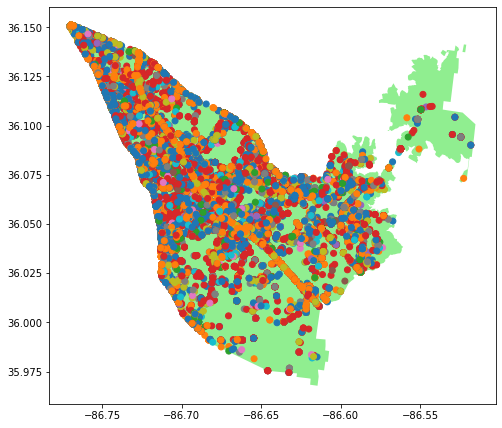

In [27]:
ax = polygonsouth.plot(figsize = (8, 10), color = 'lightgreen') # Make polygon lightgreen
ta_in_south.plot( ax = ax, column = 'Collision Type Description'); # Partition ta by Collision Type Description
plt.show();

#### Add a street map with the folium package!
- Make use of a GeoSeries attribute (.centroid) which gives the center of a polygon
- Since there are two polygons which should we use?

In [28]:
# Find the center point of polygonsouth:

polygonsouth.geometry.centroid

C:\Users\Jasmine\AppData\Local\Temp\ipykernel_11272\3053778652.py:3: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  polygonsouth.geometry.centroid


6    POINT (-86.64764 36.05903)
dtype: geometry

#### I thought there were two polygons but it only returned one center point so it's just one polygon then...?

In [29]:
# Pull the full center coordinates from that index (6):

center = polygonsouth.geometry.centroid[6]
print(center)

POINT (-86.64764171909046 36.0590275416039)


C:\Users\Jasmine\AppData\Local\Temp\ipykernel_11272\1734889227.py:3: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  center = polygonsouth.geometry.centroid[6]


#### Since the result POINT has longitude first, we have to swap the values for folium (because it likes latitude first).

In [30]:
# Reverse the order when constructing the array for folium location:
area_center = [center.y, center.x]

# Check the order of area_center, the location for our folium map:
print(area_center)

[36.0590275416039, -86.64764171909046]


In [31]:
# Create the map of the South precinct and show it:

map_south = folium.Map(location = area_center, zoom_start = 12)
map_south

#### Surprise, surprise -- it's I-24!! Time to add the South precinct polygon and traffic accident markers.

#### itterows() is a generator that iterates through the rows of a DataFrame and returns a tuple with the row id and row values.
- Below, we are printing the row values for the first 3 row as we iterate through the GeoDataFrame of bus stops in 37207.
- This idea will be helpful for creating our markers!

In [32]:
i = 0
for row_index, row_values in ta_in_south.iterrows():
    if i <3: 
        print('index is', row_index)
        print('values are:')
        print(' ')
        print(row_values)
        print('------------------------- ')
        i+=1

index is 13
values are:
 
Accident Number                              20200603733
Date and Time                            9/20/2020 13:05
Number of Motor Vehicles                             2.0
Collision Type Description    SIDESWIPE - SAME DIRECTION
Weather Description                                  NaN
Street Address                              MM 54 8 I 24
City                                           NASHVILLE
ZIP                                              37211.0
Precinct                                           SOUTH
Latitude                                         36.0968
Longitude                                       -86.7085
Mapped Location                 POINT (-86.7085 36.0968)
geometry                        POINT (-86.7085 36.0968)
index_right                                            6
precinct                                           SOUTH
Name: 13, dtype: object
------------------------- 
index is 15
values are:
 
Accident Number                           

#### Create map_south again with additional features:
- Add the South precinct outline (polygonsouth)
- Iterate through the ta_in_south to
    - Create location from each lat and long
    - Create a popup from the Collision Type Description column
    - Create a custom icon from font-awesome
    - Build a marker from each location and popup and (optionally) your custom icon
    - Add the marker to map_south
- Display map_south

In [34]:
# # Folium map the South precinct boundary:
# map_south = folium.Map(location =  area_center, zoom_start = 12)

# folium.GeoJson(polygonsouth).add_to(map_south)

# # Iterate through ta_in_south to create locations and markers 
# # for each traffic accident
# # Remember for Folium locations, lat is listed first!!

# for row_index, row_values in ta_in_south.iterrows():
#     loc = [row_values['Latitude'], row_values['Longitude']]
#     pop = str(row_values['Collision Type Description'])
#     icon=folium.Icon(color="red",icon="car", prefix='fa')
    
#     marker = folium.Marker(
#         location = loc, 
#         popup = pop, icon = icon) 

#     marker.add_to(map_south)
# map_south.save('../maps/map_south.html')

# # Display the map!
# map_south

#### Python took forever to run the above because there are 215K traffic accidents in the South precinct so I decided to use a FastMarkerCluster() instead.

In [44]:
map_south = folium.Map(location =  area_center, zoom_start = 12)

folium.GeoJson(polygonsouth).add_to(map_south)

# Create a list of locations and pass them to FastMarkerCluster()
locations = ta_in_south[['Latitude', 'Longitude']].values.tolist()
map_south.add_child(
    FastMarkerCluster(locations)
)

for x in locations:
    folium.Marker(x,
        popup=str(row_values['Collision Type Description'])
        icon=folium.Icon(color='red', icon='car', prefix='fa')
        ).add_to(cluster)

# Display the map!
map_south

#### That's a lot of traffic accidents!